## NAME: MOHAN RAM B R
## ASSIGNMENT: Waste Segregation using CNNs

## **Objective**

The objective of this project is to implement an effective waste material segregation system using convolutional neural networks (CNNs) that categorises waste into distinct groups. This process enhances recycling efficiency, minimises environmental pollution, and promotes sustainable waste management practices.

The key goals are:

* Accurately classify waste materials into categories like cardboard, glass, paper, and plastic.
* Improve waste segregation efficiency to support recycling and reduce landfill waste.
* Understand the properties of different waste materials to optimise sorting methods for sustainability.

## **Data Understanding**

The Dataset consists of images of some common waste materials.

1. Food Waste
2. Metal
3. Paper
4. Plastic
5. Other
6. Cardboard
7. Glass


# **Waste Material Segregation for Improving Waste Management**

**Data Description**

* The dataset consists of multiple folders, each representing a specific class, such as `Cardboard`, `Food_Waste`, and `Metal`.
* Within each folder, there are images of objects that belong to that category.
* However, these items are not further subcategorised. <br> For instance, the `Food_Waste` folder may contain images of items like coffee grounds, teabags, and fruit peels, without explicitly stating that they are actually coffee grounds or teabags.

## ASSUMPTIONS
#### This notebook can be run only in Google colab. It assumes that data.zip is present in a folder 'Dataset_Waste_Segregation' under 'MyDrive' folder in Google drive. 
#### Browser popup should NOT be disabled. When executed it prompts for permissions to access the Google drive folder

## **1. Load the data**

Load and unzip the dataset zip file.

**Import Necessary Libraries**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import PIL

import tensorflow as tf
from tensorflow import keras

import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import os
import zipfile

from google.colab import drive


Load the dataset.<br>
<font color=red> **!! IMPORTANT: The code below assumes that data.zip is present in a folder 'Dataset_Waste_Segregation' under 'MyDrive' folder in Google drive**

In [2]:
# Load and unzip the dataset
drive.mount('/content/drive')

IMAGE_SIZE = (128, 128)
IMAGE_MODE = 'RGB'

# Create a function to load the raw images
zip_path = '/content/drive/MyDrive/Dataset_Waste_Segregation/data.zip'
extract_path = '/content/drive/MyDrive/dataset_unzipped'
unzipped_path = extract_path + "/data"

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)



Mounted at /content/drive


## **2. Data Preparation** <font color=red> [25 marks] </font><br>


### **2.1 Load and Preprocess Images** <font color=red> [8 marks] </font><br>

Let us create a function to load the images first. We can then directly use this function while loading images of the different categories to load and crop them in a single step.

#### **2.1.1** <font color=red> [3 marks] </font><br>
Create a function to load the images.

In [3]:
# Create a function to load the raw images

def load_images_and_labels(data_dir, target_size=(128, 128)):
    images = []
    labels = []
    class_names = sorted(os.listdir(data_dir))  # Folder names as labels

    for label in class_names:
        class_dir = os.path.join(data_dir, label)
        if not os.path.isdir(class_dir):
            continue
        for filename in os.listdir(class_dir):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(class_dir, filename)
                try:
                    img = Image.open(img_path).convert('RGB').resize(target_size)
                    images.append(np.array(img))
                    labels.append(label)
                except Exception as e:
                    print(f"Skipping file {img_path}: {e}")

    return np.array(images), np.array(labels), class_names


#### **2.1.2** <font color=red> [5 marks] </font><br>
Load images and labels.

Load the images from the dataset directory. Labels of images are present in the subdirectories.

Verify if the images and labels are loaded correctly.

In [4]:
# Get the images and their labels

# limiting all images to 128x128, else this is running out of memory in colab
images, labels, class_names = load_images_and_labels(unzipped_path)
print("Before augmentation: We have following labels", set(labels))
print("Before augmentation: Number of images loaded =", len(images))
print("Before augmentation: Class names", class_names)


Before augmentation: We have following labels {np.str_('Other'), np.str_('Food_Waste'), np.str_('Metal'), np.str_('Paper'), np.str_('Cardboard'), np.str_('Plastic'), np.str_('Glass')}
Before augmentation: Number of images loaded = 7625
Before augmentation: Class names ['Cardboard', 'Food_Waste', 'Glass', 'Metal', 'Other', 'Paper', 'Plastic']


### **2.2 Data Visualisation** <font color=red> [9 marks] </font><br>

#### **2.2.1** <font color=red> [3 marks] </font><br>
Create a bar plot to display the class distribution

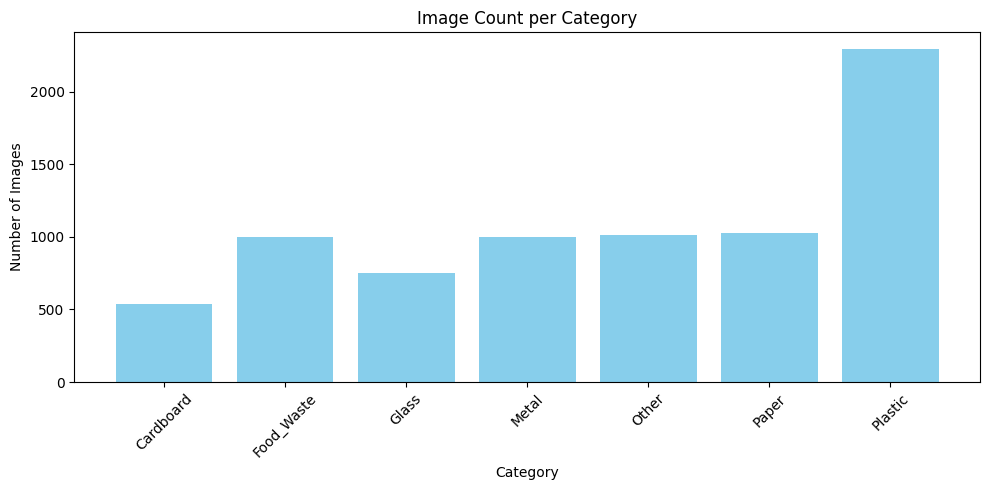

In [5]:
# Visualise Data Distribution
import matplotlib.pyplot as plt
from collections import Counter

def plot_label_distribution(labels):
    label_counts = Counter(labels)
    categories = list(label_counts.keys())
    counts = list(label_counts.values())

    plt.figure(figsize=(10, 5))
    plt.bar(categories, counts, color='skyblue')
    plt.xlabel('Category')
    plt.ylabel('Number of Images')
    plt.title('Image Count per Category')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_label_distribution(labels)



#### **2.2.2** <font color=red> [3 marks] </font><br>
Visualise some sample images

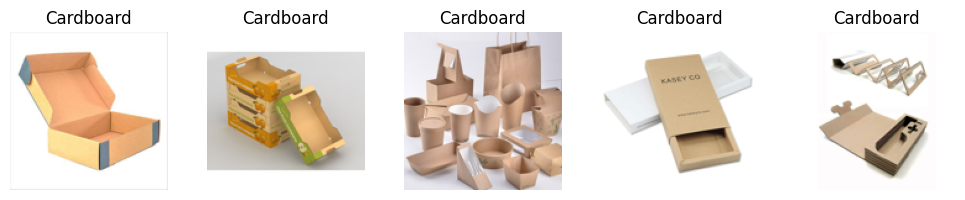

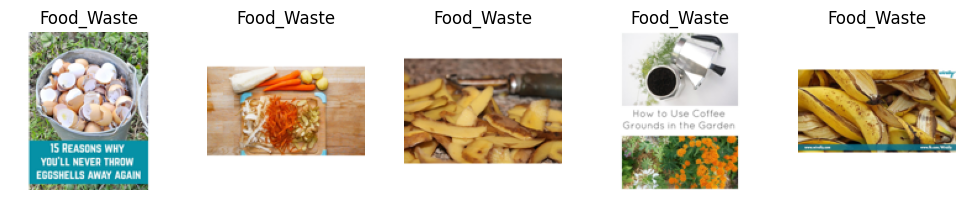

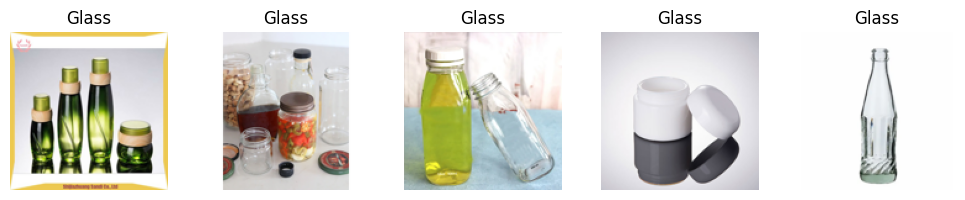

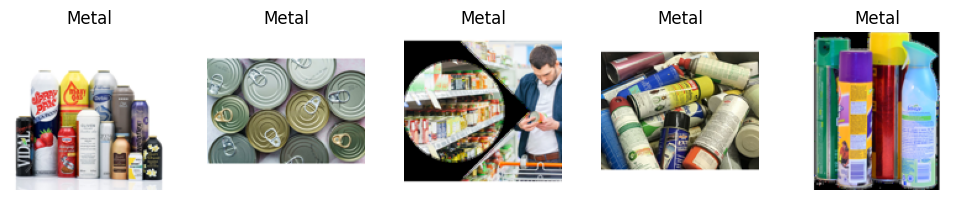

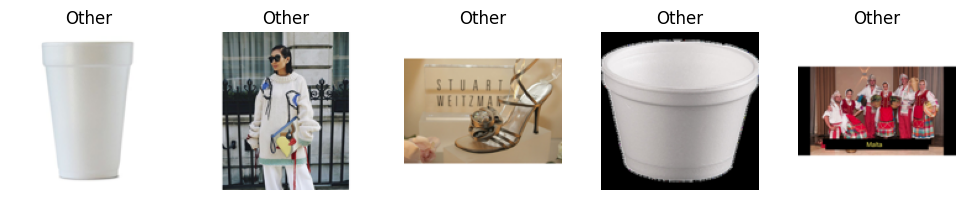

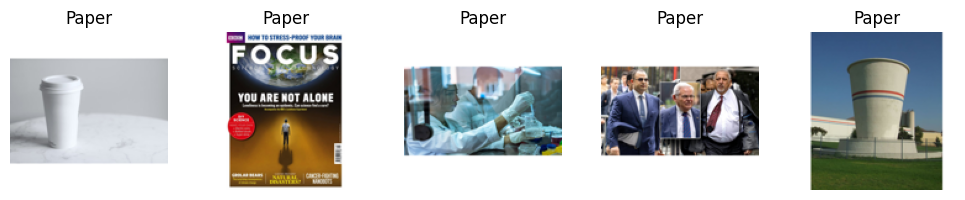

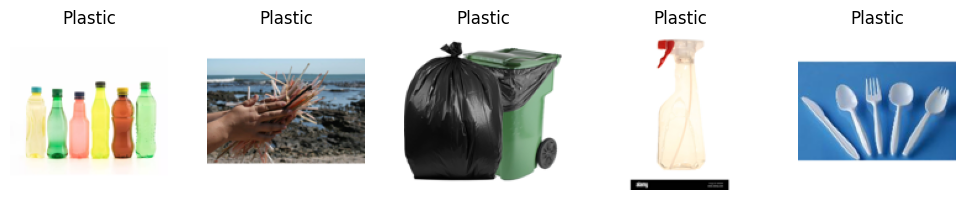

In [6]:
# Visualise Sample Images (across different labels)
import random

def show_sample_images(images, labels, samples_per_class=5):
    from collections import defaultdict
    import random

    label_to_indices = defaultdict(list)
    for idx, label in enumerate(labels):
        label_to_indices[label].append(idx)

    for label, indices in label_to_indices.items():
        selected = random.sample(indices, min(samples_per_class, len(indices)))
        plt.figure(figsize=(samples_per_class * 2, 2))
        for i, idx in enumerate(selected):
            plt.subplot(1, samples_per_class, i + 1)
            plt.imshow(images[idx])
            plt.axis('off')
            plt.title(label)
        plt.tight_layout()
        plt.show()

show_sample_images(images, labels, samples_per_class=5)


#### **2.2.3** <font color=red> [3 marks] </font><br>
Based on the smallest and largest image dimensions, resize the images.

In [7]:
# Find the smallest and largest image dimensions from the data set

def get_image_size_stats(images):
    widths = [img.shape[1] for img in images]
    heights = [img.shape[0] for img in images]

    min_width = min(widths)
    max_width = max(widths)
    min_height = min(heights)
    max_height = max(heights)

    print(f"Minimum Width: {min_width}, Maximum Width: {max_width}")
    print(f"Minimum Height: {min_height}, Maximum Height: {max_height}")
    return (min_width, min_height), (max_width, max_height)

(min_width, min_height), (max_width, max_height) = get_image_size_stats(images)

Minimum Width: 128, Maximum Width: 128
Minimum Height: 128, Maximum Height: 128


In [8]:
# Resize the image dimensions
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img

def resize_images(images, width, height):
    resized = []
    for img in images:
        pil_img = array_to_img(img)
        pil_resized = pil_img.resize((width, height))  # force resize
        resized.append(img_to_array(pil_resized))
    return np.array(resized)

images_resized = resize_images(images, min_width, min_height)


#### **2.2.4** As there is a large skew in input dataest, augment the classes with less samples and remove some samples (random) from "Plastic" class <font color=red> </font><br>

In [9]:
def downsample_class(X, y, label_to_reduce, max_count):
    # Find indices for the target class and all other classes
    idx_target_class = np.where(y == label_to_reduce)[0]
    idx_other_classes = np.where(y != label_to_reduce)[0]

    # Randomly choose `max_count` samples from the overrepresented class
    np.random.shuffle(idx_target_class)
    idx_target_class = idx_target_class[:max_count]

    # Combine and shuffle the new indices
    selected_indices = np.concatenate((idx_target_class, idx_other_classes))
    np.random.shuffle(selected_indices)

    # Subset the arrays
    X_balanced = X[selected_indices]
    y_balanced = y[selected_indices]

    return X_balanced, y_balanced


In [10]:
# augmentation function for other classes with less samples.

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from collections import Counter
import random

def augment_minority_classes(X, y, target_count_per_class=1500):

    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    class_counts = Counter(y)
    X_augmented, y_augmented = [], []

    for label in np.unique(y):
        X_class = X[y == label]
        count = class_counts[label]

        if count >= target_count_per_class:
            continue
        shortfall = target_count_per_class - count
        print(f"Augmenting class {label}: current={count}, augmenting={shortfall}")

        # Pick samples randomly from class
        samples = random.choices(X_class, k=shortfall)
        samples = np.array(samples)

        # Flow with batch_size=1 for simplicity
        gen = datagen.flow(samples, batch_size=1, shuffle=False)
        for _ in range(shortfall):
            X_augmented.append(next(gen)[0])  # get the image
            y_augmented.append(label)

    # Combine original + augmented
    X_combined = np.concatenate([X, np.array(X_augmented)], axis=0)
    y_combined = np.concatenate([y, np.array(y_augmented)], axis=0)

    return X_combined, y_combined


In [11]:
# First remove samples from 'Plastic', then augment others
# Trying do otherway is causing OOM restart
images_resized, labels = downsample_class(images_resized, labels, 'Plastic', 1600)

In [12]:
images_resized, labels = augment_minority_classes(images_resized, labels, target_count_per_class=1600)
print("After Augmentation: We have following labels", set(labels))
print("After Augmentation: Number of images loaded =", len(images_resized))
print("After Augmentation: Class names", class_names)


Augmenting class Cardboard: current=540, augmenting=1060
Augmenting class Food_Waste: current=1000, augmenting=600
Augmenting class Glass: current=750, augmenting=850
Augmenting class Metal: current=1000, augmenting=600
Augmenting class Other: current=1010, augmenting=590
Augmenting class Paper: current=1030, augmenting=570
After Augmentation: We have following labels {np.str_('Other'), np.str_('Food_Waste'), np.str_('Metal'), np.str_('Cardboard'), np.str_('Glass'), np.str_('Plastic'), np.str_('Paper')}
After Augmentation: Number of images loaded = 11200
After Augmentation: Class names ['Cardboard', 'Food_Waste', 'Glass', 'Metal', 'Other', 'Paper', 'Plastic']


### **2.3 Encoding the classes** <font color=red> [3 marks] </font><br>

There are seven classes present in the data.

We have extracted the images and their labels, and visualised their distribution. Now, we need to perform encoding on the labels. Encode the labels suitably.

####**2.3.1** <font color=red> [3 marks] </font><br>
Encode the target class labels.

In [13]:
from sklearn import preprocessing
labels_orig = labels
label_encoder = preprocessing.LabelEncoder()

labels = label_encoder.fit_transform(labels_orig)
print('Encoded labels', set(labels))
print('Encoded labels', labels)

# normalize pixel values
images_resized = images_resized.astype('float32')/255.0



Encoded labels {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6)}
Encoded labels [2 6 5 ... 5 5 5]


### **2.4 Data Splitting** <font color=red> [5 marks] </font><br>

#### **2.4.1** <font color=red> [5 marks] </font><br>
Split the dataset into training and validation sets

In [14]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images_resized, labels, test_size=0.2, random_state=42)

def prepare_tf_dataset(images, labels, batch_size=64, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(images))
    dataset = dataset.batch(batch_size)
    return dataset


tf_dataset_train = prepare_tf_dataset(X_train, y_train)
tf_dataset_test = prepare_tf_dataset(X_test, y_test, shuffle=False)


## **3. Model Building and Evaluation** <font color=red> [20 marks] </font><br>

### **3.1 Model building and training** <font color=red> [15 marks] </font><br>

#### **3.1.1** <font color=red> [10 marks] </font><br>
Build and compile the model. Use 3 convolutional layers. Add suitable normalisation, dropout, and fully connected layers to the model.

Test out different configurations and report the results in conclusions.

In [15]:
# Build and compile the model

# Build and compile the model

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.regularizers import l2

input_shape = (128, 128, 3)
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', padding='same', input_shape=input_shape))
model.add(BatchNormalization())
#model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(3,3), kernel_regularizer=l2(0.005), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax'))

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])



/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### **3.1.2** <font color=red> [5 marks] </font><br>
Train the model.

Use appropriate metrics and callbacks as needed.

In [16]:
# Training
# Adding callback to stop training early if threshold is reached
from tensorflow.keras.callbacks import Callback

class EarlyStoppingByAccuracy(Callback):
    def __init__(self, threshold):
        super(EarlyStoppingByAccuracy, self).__init__()
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        val_acc = logs.get("val_accuracy")
        if val_acc is not None:
            if val_acc >= self.threshold:
                print(f"\nStopping training as val_accuracy reached {val_acc:.4f}")
                self.model.stop_training = True

threshold_accuracy = 0.75
early_stop_callback = EarlyStoppingByAccuracy(threshold=threshold_accuracy)

model.fit(tf_dataset_train, epochs=90, verbose=1, validation_data=tf_dataset_test, callbacks=[early_stop_callback])


Epoch 1/90
140/140 ━━━━━━━━━━━━━━━━━━━━ 36s 113ms/step - accuracy: 0.2255 - loss: 20.2179 - val_accuracy: 0.1491 - val_loss: 11.3135
Epoch 2/90
140/140 ━━━━━━━━━━━━━━━━━━━━ 13s 94ms/step - accuracy: 0.2907 - loss: 6.3612 - val_accuracy: 0.1589 - val_loss: 4.6268
Epoch 3/90
140/140 ━━━━━━━━━━━━━━━━━━━━ 21s 95ms/step - accuracy: 0.3188 - loss: 3.3744 - val_accuracy: 0.2799 - val_loss: 3.1626
Epoch 4/90
140/140 ━━━━━━━━━━━━━━━━━━━━ 13s 96ms/step - accuracy: 0.3344 - loss: 2.8558 - val_accuracy: 0.3134 - val_loss: 3.1704
Epoch 5/90
140/140 ━━━━━━━━━━━━━━━━━━━━ 14s 97ms/step - accuracy: 0.3718 - loss: 2.7214 - val_accuracy: 0.2254 - val_loss: 2.7378
Epoch 6/90
140/140 ━━━━━━━━━━━━━━━━━━━━ 21s 98ms/step - accuracy: 0.3821 - loss: 2.5647 - val_accuracy: 0.2714 - val_loss: 2.9681
Epoch 7/90
140/140 ━━━━━━━━━━━━━━━━━━━━ 21s 102ms/step - accuracy: 0.3869 - loss: 2.7538 - val_accuracy: 0.3661 - val_loss: 2.4800
Epoch 8/90
140/140 ━━━━━━━━━━━━━━━━━━━━ 14s 100ms/step - accuracy: 0.3954 - loss: 2.21

## RESULTS SUMMARY
### <font color=red>WITHOUT AUGMENTATION


#### With 2 and 3 CNN layers, the validation accuracy did not go above 0.5 without overfitting
#### Increased to 6 CNN layers and increased epochs in steps. Results below
#### FOR EACH CASE BELOW VALIDATION ACCURACY HAS BEEN MENTIONED AFTER ':'
#### ALL CASES BELOW WITH: FC 512 layer with batch normalization
#### 6 layers, batch_size=32, epoch=20: 0.31
#### 6 layers, batch_size=32, epoch=30: 0.55
#### 6 layers, batch_size=32, epoch=50: 0.64
#### 6 layers, batch_size=64, epoch=50: 0.62
#### 6 layers, batch_size=64, epoch=80, 0.728 but train_accuracy=0.93 (overfitted)
####  <font color=yellow> BEST RESULT WITHOUT AUGMENTATION WITH TRAINING STOPPED BY VAL_ACCURACY THRESHOLD:
#### 6 layers, batch_size=64, epoch=46: 0.714 (train accuracy: 0.87)

###  <font color=red>WITH AUGMENTATION
#### 6 layers, batch_size=32, epoch=72: 0.744 (train accuracy: 0.783) - Slightly better validation accuracy with lesser overfitting
#### 6 layers, batch_size=64, epoch=64: 0.76 (train accuracy: 0.89) -


### **3.2 Model Testing and Evaluation** <font color=red> [5 marks] </font><br>

#### **3.2.1** <font color=red> [5 marks] </font><br>
Evaluate the model on test dataset. Derive appropriate metrics.

In [17]:
# Evaluate on the test set; display suitable metrics
test_loss, test_accuracy = model.evaluate(tf_dataset_test)
from sklearn.metrics import confusion_matrix, classification_report

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.7740 - loss: 1.9953
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step
Confusion Matrix:
[[277  21   1   0   4   9   3]
 [  1 281   1   0   8  15   7]
 [  5  16 253   8  20   6  26]
 [  1  13   5 239  17  31  12]
 [  4  29   3   2 222  47  17]
 [ 11  25   5   5  21 241  14]
 [  1  14  14   5  36  44 200]]

Classification Report:
              precision    recall  f1-score   support

   Cardboard       0.92      0.88      0.90       315
  Food_Waste       0.70      0.90      0.79       313
       Glass       0.90      0.76      0.82       334
       Metal       0.92      0.75      0.83       318
       Other       0.68      0.69      0.68       324
       Paper       0.61      0.75      0.67       322
     Plastic       0.72      0.64      0.67       314

    accuracy                           0.76      2240
   macro avg       0.78      0.77      0.77      2240
weighted avg       0.78      0.76      0.77      2240



## **4. Data Augmentation** <font color=red> [optional] </font><br>

## Data augmentation has been included in the previous cells


## **5. Conclusions** <font color = red> [5 marks]</font>

#### **5.1 Conclude with outcomes and insights gained** <font color =red> [5 marks] </font>

* Report your findings about the data
1. The number of images for different image classes is non-uniform. There are more than 2000 images for Plastic but less than 800 for Glass and Cardboard
2. Images are 256x256. Processing them at the original size caused OOM errors
3. Number of images in all classes was either augmented or trimmed to 1500
4. Image were truncated to 128x128
* Report model training results
1. With 2 and 3 CNN layers, the results were poor. With more epoch, the model overfitted training data close to 100% and validation accuracy could not exceed 60%
2. After adding 6 CNN layers with more dropouts and additional kernel l2 regularization and more epochs, started seeing less overfitting and validation accuracy exceeding 70%
3. Added callback to stop fitting when validation accuracy exceeded 70%.<br>
3a. Best results with augmentation, at epoch 64, batch size 64: <br>
`accuracy: 0.8924 - loss: 1.5893 - val_accuracy: 0.7647 - val_loss: 1.9940`<br>
3b. Best results without augmentation, at epoch 87, batch size 32:<br>
`accuracy: 0.87 val_accuracy: 0.71`<br>
4. Final validation score - `accuracy: 0.7740 - loss: 1.9953`
5. Generated confusion matrix and classification report - Class 'other' had the lowest accuracy which is expected due to having different types of images. Class 'Plastic' was next lowest, probably due to removing some images from the samples due to OOM error.